# Task II

# My Approaches

I have chosen **ParticleNet** and **EdgeConv** models for the Classical Graph Neural Network training.

### 1. EdgeConv

EdgeConv is a special building block for convolutional neural networks (CNNs) that works well for complex tasks involving point clouds, like classifying or separating objects. Unlike other methods, it focuses on connections between points (edges) to understand how they relate to each other. It achieves this by creating a dynamic graph that constantly updates based on the data at each layer. This graph connects points that are closest together (k-nearest neighbors), which are determined by the information processing throughout the network.



<p align="center">
    <img src="https://dl.acm.org/cms/attachment/97cd1684-a354-4e86-9698-a6cd5508c1b2/tog3805-146-f02.jpg" alt="EdgeConv"/>
    <br>
    Figure: The EdgeConv operation.
</p>







### 2. ParticleNet

ParticleNet is a system built using three EdgeConv blocks, one after another. The first block relies on the particles' positions (in a specific coordinate system) to figure out how close they are. The following blocks, however, use the features learned by the previous block to determine closeness instead of raw positions. ParticleNet Lite has a similar design, also leveraging EdgeConv to understand how nearby points in the point cloud data are related. It uses two EdgeConv blocks, and for both, it considers the 7 closest neighbors around each point.



<p align="center">
    <img src="https://cms-ml.github.io/documentation/images/inference/particlenet_full_arch.png" alt="Particle Net"/>
    <br>
    Figure: The architecture of the ParticleNet model.
</p>






### Dataset

The dataset used in this project was actually used in P. T. Komiske, E. M. Metodiev, J. Thaler, Energy Flow Networks: Deep Sets for Particle Jets, JHEP 01 (2019) 121, arXiv:1810.05165.

It has 20 files consisting of jet data with each file having 100k samples.There are two arrays in each file

- X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.
- y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.
However due to hardware limitations, we use only the first file of the complete dataset i.e. 100k total samples of data in this project.

The jets are padded with zero-particles in order to make a contiguous array. The particles are given as (pt,y,phi,pid) values, where-

- pid is the particle's PDG ID
- pt is Transverse Momentum
- y is Rapidity
- phi is Azimuthal Angle
Using the dataset I have create three dictionaries that contains the "points", "features", and "mask" array for training set, validation set, and testing set-

points contains only rapidity and azimuthal angle value as coordinates, this will be used to calculate distance for k-NN.
features contains tranverse momentum, rapidity, and Azimuthal angle.
mask gives information whether the particle is a real particle from the dataset or just a padded "zero-particles" (taking value of zero for the padded positions).

# Implementations

## Setup

In [ ]:
%%capture
!pip install tensorflow energyflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import energyflow
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score

### Functions

In [ ]:
def batch_distance_matrix_general(A, B):
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(topk_indices, features):
    '''
    topk_indices (tuple/list): (N, P, K)
    features (tuple/list): (N, P, C)
    '''
    with tf.name_scope('knn'):
        k = tf.shape(topk_indices)[-1]
        num_points = tf.shape(features)[-2]
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)

# 1. Particle Net

In [ ]:
X, y = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia', with_bc=False, cache_dir='~/.energyflow')
y=tf.keras.utils.to_categorical(y)

URL fetch failure on https://www.dropbox.com/s/fclsl7pukcpobsb/QG_jets.npz?dl=1: None -- Not Found
Failed to download QG_jets.npz from source 'dropbox', trying next source...


In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

num_particles = x_train.shape[1]

print(x_train.shape, x_val.shape, x_test.shape)

(75000, 139, 4) (15000, 139, 4) (10000, 139, 4)


In [ ]:
# masking train data
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_train = np.sum(x_train, axis=2)

# make the array binary
mask_train = np.array(mask_train != 0, np.float32)

# reshape mask for a third axis
mask_train = mask_train.reshape(x_train.shape[0], x_train.shape[1], 1)

print(mask_train.shape)

(75000, 139, 1)


In [ ]:
# masking test data
mask_test = np.sum(x_test, axis=2)
mask_test = np.array(mask_test != 0,np.float32)
mask_test = mask_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# masking validation data
mask_val = np.sum(x_val, axis=2)
mask_val = np.array(mask_val !=0, np.float32)
mask_val = mask_val.reshape(x_val.shape[0], x_val.shape[1],1)

print(mask_test.shape, mask_val.shape)

(10000, 139, 1) (15000, 139, 1)


In [ ]:
train_dataset = {
    # the co-ordinates of particles in (rapidity, azimuthal angle) space
    'points' : x_train[:,:,1:3],
    # the features of each particle are its pt, rapidity, azimuthal angle
    'features' : x_train,
    # mask
    'mask': mask_train
    }

test_dataset = {
    'points': x_test[:, :, 1:3],
    'features': x_test,
    'mask': mask_test
}

val_dataset = {
    'points': x_val[:, :, 1:3],
    'features': x_val,
    'mask': mask_val
}

In [ ]:
shapes = {
    'points': x_train[:, :, 1:3].shape[1:],
    'features': x_train.shape[1:],
    'mask': mask_train.shape[1:]
}
shapes

{'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}

In [ ]:
def edge_conv(points, features, num_points, K, channels, with_bn=True, activation='relu', pooling='average', name='edgeconv'):
    '''
    Inputs:
        points: (N, P, C_p)
        features: (N, P, C_0)
    Outputs:
        transformed points: (N, P, C_out), C_out = channels[-1]
    '''

    with tf.name_scope('edgeconv'):

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=K + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K)

        fts = features
        knn_fts = knn(indices, fts)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(fts, axis=2), (1, 1, K, 1))  # (N, P, K, C)
        knn_fts = tf.concat([knn_fts_center, tf.subtract(knn_fts, knn_fts_center)], axis=-1)  # (N, P, K, 2*C)

        x = knn_fts
        for idx, channel in enumerate(channels):
            x = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=1, data_format='channels_last',
                                    use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_conv%d' % (name, idx))(x)
            if with_bn:
                x = keras.layers.BatchNormalization(name='%s_bn%d' % (name, idx))(x)
            if activation:
                x = keras.layers.Activation(activation, name='%s_act%d' % (name, idx))(x)

        if pooling == 'max':
            fts = tf.reduce_max(x, axis=2)  # (N, P, C')
        else:
            fts = tf.reduce_mean(x, axis=2)  # (N, P, C')

        # shortcut
        sc = keras.layers.Conv2D(channels[-1], kernel_size=(1, 1), strides=1, data_format='channels_last',
                                 use_bias=False if with_bn else True, kernel_initializer='glorot_normal', name='%s_sc_conv' % name)(tf.expand_dims(features, axis=2))
        if with_bn:
            sc = keras.layers.BatchNormalization(name='%s_sc_bn' % name)(sc)
        sc = tf.squeeze(sc, axis=2)

        if activation:
            return keras.layers.Activation(activation, name='%s_sc_act' % name)(sc + fts)  # (N, P, C')
        else:
            return sc + fts


def _particle_net_base(points, features=None, mask=None, setting=None, name='particle_net'):
    '''
    points : (N, P, C_coord)
    features:  (N, P, C_features), optional
    mask: (N, P, 1), optinal
    '''
    with tf.name_scope(name):
        if features is None:
            features = points

        if mask is not None:
            mask = tf.cast(tf.not_equal(mask, 0), dtype='float32')  # 1 if valid
            coord_shift = tf.multiply(999., tf.cast(tf.equal(mask, 0), dtype='float32'))  # make non-valid positions to 99

        fts = tf.squeeze(keras.layers.BatchNormalization(name='%s_fts_bn' % name)(tf.expand_dims(features, axis=2)), axis=2)
        for layer_idx, layer_param in enumerate(setting.conv_params):
            K, channels = layer_param
            pts = tf.add(coord_shift, points) if layer_idx == 0 else tf.add(coord_shift, fts)
            fts = edge_conv(pts, fts, setting.num_points, K, channels, with_bn=True, activation='relu',
                            pooling=setting.conv_pooling, name='%s_%s%d' % (name, 'EdgeConv', layer_idx))

        if mask is not None:
            fts = tf.multiply(fts, mask)

        pool = tf.reduce_mean(fts, axis=1)  # (N, C)

        if setting.fc_params is not None:
            x = pool
            for layer_idx, layer_param in enumerate(setting.fc_params):
                units, drop_rate = layer_param
                x = keras.layers.Dense(units, activation='relu')(x)
                if drop_rate is not None and drop_rate > 0:
                    x = keras.layers.Dropout(drop_rate)(x)
            out = keras.layers.Dense(setting.num_class, activation='softmax')(x)
            return out  # (N, num_classes)
        else:
            return
class _DotDict:
    pass

def get_particle_net_lite(num_classes, input_shapes):

    setting = _DotDict()
    setting.num_class = num_classes
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (7, (32, 32, 32)),
        (7, (64, 64, 64)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = [(128, 0.1)]
    setting.num_points = input_shapes['points'][0]

    points = keras.Input(name='points', shape=input_shapes['points'])
    features = keras.Input(name='features', shape=input_shapes['features']) if 'features' in input_shapes else None
    mask = keras.Input(name='mask', shape=input_shapes['mask']) if 'mask' in input_shapes else None
    outputs = _particle_net_base(points, features, mask, setting, name='ParticleNet')

    return keras.Model(inputs=[points, features, mask], outputs=outputs, name='ParticleNet')

### Experiment

In [ ]:
# particle net lite
num_classes = 2
model = get_particle_net_lite(num_classes, shapes)

In [ ]:
# Training parameters
batch_size = 512
epochs = 15


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
    elif epoch > 10:
        lr *= 0.01
    return lr

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()

callbacks = [lr_scheduler, progress_bar, early_stop]

history = model.fit(train_dataset, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_dataset, y_val),
                    shuffle=True,
                    callbacks=callbacks)

In [ ]:
y_val_cat_prob = model.predict_on_batch( test_dataset )

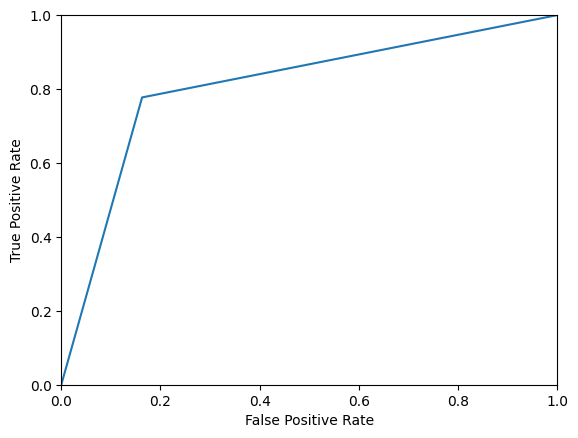

In [ ]:
fpr , tpr , thresholds = roc_curve(y_test.argmax(axis=1), y_val_cat_prob.argmax(axis=1) )

plt.plot(fpr,tpr)
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
auc_score = roc_auc_score(y_test.argmax(axis=1), y_val_cat_prob.argmax(axis=1) )
auc_score

0.8071805148882383

# 2. EdgeConv

In [ ]:
X, y = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',
                        with_bc=False, cache_dir='~/.energyflow')

In [ ]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10


# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, shuffle=True)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))


print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape,"\t", y_test.shape, "\t", y_val.shape)

(75000, 139, 4) (10000, 139, 4) (15000, 139, 4)
(75000,) 	 (10000,) 	 (15000,)


In [ ]:
from tensorflow.keras import layers as lay

class SplitLayer(lay.Layer):

    def __init__(self, n_splits=12, split_axis=-1, **kwargs):
        self.n_splits = n_splits
        self.split_axis = split_axis
        super(SplitLayer, self).__init__(**kwargs)

    def get_config(self):
        config = {'n_splits': self.n_splits,
                  'split_axis': self.split_axis}
        base_config = super(SplitLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x):
        ''' return array of splitted tensors '''
        sub_tensors = tf.split(x, self.n_splits, axis=self.split_axis)
        return sub_tensors

    def compute_output_shape(self, input_shape):
        sub_tensor_shape = list(input_shape)
        num_channels = sub_tensor_shape[self.split_axis]
        sub_tensor_shape[self.split_axis] = int(num_channels / self.n_splits)
        sub_tensor_shape = tuple(sub_tensor_shape)
        list_of_output_shape = [sub_tensor_shape] * self.n_splits
        return list_of_output_shape

    def compute_mask(self, inputs, mask=None):
        return self.n_splits * [None]

def f(data):
    d1, d2 = data
    dif = lay.Subtract()([d1, d2])
    x = lay.Concatenate(axis=-1)([d1, dif])
    x = lay.Dense(64)(x)
    x = lay.Dense(32)(x)
    return x

class EdgeConv(lay.Layer):
    '''
    # Input shape
        List of two tensors [points, features] with shape:
        `[(batch, P, C_p), (batch, P, C_f)]`.
        or tensor with shape:
        `(batch, P, C)`
        if points (coordinates) and features are supposed to be the same.
    # Output shape
        Tensor with shape:
        `(batch, P, C_h)`
        with C_h being the output dimension of the h-function.
    '''

    def __init__(self, kernel_func, next_neighbors, agg_func=keras.backend.mean, **kwargs):
        self.kernel_func = kernel_func
        self.next_neighbors = next_neighbors
        self.agg_func = agg_func
        if type(agg_func) == str:
            raise ValueError("No such agg_func '%s'. When loading the model specify the agg_func '%s' via custom_objects" % (agg_func, agg_func))
        super(EdgeConv, self).__init__(**kwargs)

    def get_config(self):
        config = {'next_neighbors': self.next_neighbors,
                  'kernel_func': self.kernel_func,
                  'agg_func': self.agg_func}
        base_config = super(EdgeConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        try:
            p_shape, f_shape = input_shape
        except ValueError:
            f_shape = input_shape

        if type(self.kernel_func) != keras.models.Model:  # for not wrapping model around model when loading model
            x = lay.Input((f_shape.as_list()[-1] * 2,))
            a = lay.Reshape((2, f_shape.as_list()[-1]))(x)
            x1, x2 = SplitLayer(n_splits=2, split_axis=-2)(a)  # (2, C)
            x1 = lay.Reshape((f_shape.as_list()[-1],))(x1)
            x2 = lay.Reshape((f_shape.as_list()[-1],))(x2)
            y = self.kernel_func([x1, x2])
            self.kernel_func = keras.models.Model(x, y)

        super(EdgeConv, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        try:
            points, features = x
        except TypeError:
            points = features = x

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=self.next_neighbors + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K) remove self connection
        knn_fts = knn(indices, features)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(features, axis=2), (1, 1, self.next_neighbors, 1))  # (N, P, K, C)
        knn_fts = tf.concat([knn_fts_center, knn_fts], axis=-1)  # (N, P, K, 2*C)
        res = lay.TimeDistributed(lay.TimeDistributed(self.kernel_func))(knn_fts)  # (N, P, K, C')
        # aggregation
        agg = self.agg_func(res, axis=2)  # (N, P, C')
        return agg

    def compute_output_shape(self, input_shape):
        self.output_shape = self.kernel_func.get_output_shape_at(-1)
        return self.output_shape

In [ ]:
points = lay.Input((X_train.shape[1],2))
feats = lay.Input((X_train.shape[1],2))
a = EdgeConv(f, next_neighbors=3)([points, feats])
y = EdgeConv(f, next_neighbors=3)(a)
oute = EdgeConv(f, next_neighbors=3)(y)
pool = lay.GlobalAveragePooling1D()(oute)
x = lay.Dense(64)(pool)
x = lay.Dense(32)(pool)
out = lay.Dense(1, activation="sigmoid")(x)

model = keras.models.Model([points, feats], out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 139, 2)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 139, 2)]             0         []                            
                                                                                                  
 edge_conv (EdgeConv)        (None, 139, 32)              2400      ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 edge_conv_1 (EdgeConv)      (None, 139, 32)              6240      ['edge_conv[0][0]']       

In [ ]:
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.005),
              metrics=[keras.metrics.BinaryAccuracy()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
epochs = 5
batch_size = 1024

hist = model.fit([X_train[:,:,1:3], X_train[:,:,[0,3]]], y_train, batch_size=batch_size, epochs=epochs, validation_data=([X_val[:,:,1:3], X_val[:,:,[0,3]]], y_val), callbacks=[early_stopping])


Epoch 1/5
74/74 [==============================] - 308s 4s/step - loss: 0.6021 - binary_accuracy: 0.6749 - val_loss: 0.5849 - val_binary_accuracy: 0.6929
Epoch 2/5
74/74 [==============================] - 327s 4s/step - loss: 0.5803 - binary_accuracy: 0.6982 - val_loss: 0.5894 - val_binary_accuracy: 0.6891
Epoch 3/5
74/74 [==============================] - 314s 4s/step - loss: 0.5858 - binary_accuracy: 0.6926 - val_loss: 0.5793 - val_binary_accuracy: 0.6956
Epoch 4/5
74/74 [==============================] - 315s 4s/step - loss: 0.5845 - binary_accuracy: 0.6954 - val_loss: 0.5786 - val_binary_accuracy: 0.6967
Epoch 5/5
74/74 [==============================] - 333s 5s/step - loss: 0.5854 - binary_accuracy: 0.6936 - val_loss: 0.5792 - val_binary_accuracy: 0.6978


In [ ]:
y_val_cat_prob = model.predict_on_batch([X_test[:,:,1:3], X_test[:,:,[0,3]]])

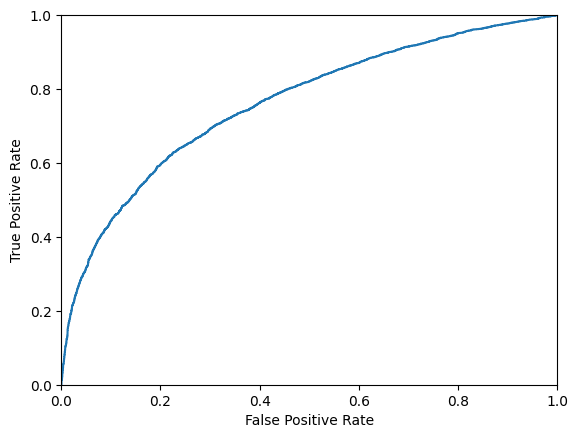

In [ ]:
fpr , tpr , thresholds = roc_curve (y_test, y_val_cat_prob)

plt.plot(fpr,tpr)
plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
auc_score=roc_auc_score(y_test,y_val_cat_prob)
auc_score

0.7610772195280161